# BTCUSDT Analysis
In this file I will deal with the historical analysis of BTCUSDT using market indicators, statistical methods and machine learning techniques to create an operational strategy

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

plt.style.use('seaborn-whitegrid')

In [2]:
import sys
sys.path.insert(0, r"C:\Users\axeli\Desktop\Github\crypto-trading\Scraping")

## Updating Files
Use the crypto scraper extension to update the datasets

In [3]:
f_list = [
    r"C:\Users\axeli\Desktop\Github\crypto-trading\Data Analysis\CSV\BTCUSDT 5.csv",
    r"C:\Users\axeli\Desktop\Github\crypto-trading\Data Analysis\CSV\BTCUSDT 15.csv"
]

In [4]:
import crypto_scraper as cs
from pybit import usdt_perpetual

session_unauth = usdt_perpetual.HTTP(
    endpoint="https://api-testnet.bybit.com"
)

bybit_scr = cs.ByBit_Scraper(session_unauth)

for f in f_list:
    bybit_scr.set_dataframe(pd.read_csv(f))
    bybit_scr.update_history()
    bybit_scr.to_csv(f)

BTCUSDT Starting Updating ...
	Extraction Time: 2022-10-09 14:30:00
Ending Updating ...
Creating .csv file ...
BTCUSDT Starting Updating ...
	Extraction Time: 2022-10-09 14:30:00
Ending Updating ...
Creating .csv file ...


## Exploratory Data Analysis - BTCUSDT 15
After updating our datasets we can explorate our time serie

In [5]:
btc15 = pd.read_csv(f_list[1])
btc15

,symbol,period,start_at,datetime,open,high,low,close
0,BTCUSDT,15,1581938100,2020-02-17 11:15:00,9632.88,9658.14,9629.56,9658.14
1,BTCUSDT,15,1581939000,2020-02-17 11:30:00,9658.14,9701.11,9588.07,9604.98
2,BTCUSDT,15,1581939900,2020-02-17 11:45:00,9604.98,9640.91,9583.22,9600.32
3,BTCUSDT,15,1581940800,2020-02-17 12:00:00,9600.32,9648.28,9579.85,9613.43
4,BTCUSDT,15,1581941700,2020-02-17 12:15:00,9613.43,9656.98,9611.24,9643.22
...,...,...,...,...,...,...,...,...
92709,BTCUSDT,15,1665324900,2022-10-09 14:15:00,19492.17,19492.61,19454.84,19479.00
92710,BTCUSDT,15,1665325800,2022-10-09 14:30:00,19478.00,19504.06,19475.50,19494.65
92711,BTCUSDT,15,1665326700,2022-10-09 14:45:00,19494.65,19519.63,19491.78,19499.93
92712,BTCUSDT,15,1665327600,2022-10-09 15:00:00,19499.93,19525.00,19499.84,19510.98


In [6]:
# The first step is to reshape the dataset
btc15 = btc15.iloc[:, 3:].set_index('datetime')
btc15

,open,high,low,close
datetime,,,,
2020-02-17 11:15:00,9632.88,9658.14,9629.56,9658.14
2020-02-17 11:30:00,9658.14,9701.11,9588.07,9604.98
2020-02-17 11:45:00,9604.98,9640.91,9583.22,9600.32
2020-02-17 12:00:00,9600.32,9648.28,9579.85,9613.43
2020-02-17 12:15:00,9613.43,9656.98,9611.24,9643.22
...,...,...,...,...
2022-10-09 14:15:00,19492.17,19492.61,19454.84,19479.00
2022-10-09 14:30:00,19478.00,19504.06,19475.50,19494.65
2022-10-09 14:45:00,19494.65,19519.63,19491.78,19499.93


In [7]:
# Let's check basic informations
print(btc15.info(), '\n', btc15.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 92714 entries, 2020-02-17 11:15:00 to 2022-10-09 15:15:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    92714 non-null  float64
 1   high    92714 non-null  float64
 2   low     92714 non-null  float64
 3   close   92714 non-null  float64
dtypes: float64(4)
memory usage: 3.5+ MB
None 
                open          high           low         close
count  92714.000000  92714.000000  92714.000000  92714.000000
mean   30794.024027  30875.819228  30710.783581  30794.130958
std    17277.082067  17323.905710  17229.590447  17276.982107
min     3881.730000   4242.120000   3793.730000   3881.730000
25%    11859.137500  11872.550000  11840.015000  11859.352500
50%    31772.955000  31883.130000  31670.300000  31772.955000
75%    45015.110000  45153.892500  44856.170000  45015.110000
max    68751.930000  69031.900000  68595.550000  68751.930000


In [8]:
# Perfect! There are no null values.
# Now we see the type of values with which we are going to operate
btc15.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

## Find a Strategy
After checking the integrity of the data we move on to extrapolating data to create a strategy
### Analyze Candles

In [9]:
btc15['perc_ret'] = btc15['close']/btc15['open'] - 1        # Candle Percentage Return
btc15['log_ret'] = np.log(btc15['close']/btc15['open'])     # Candle Logarithmic Return
btc15

,open,high,low,close,perc_ret,log_ret
datetime,,,,,,
2020-02-17 11:15:00,9632.88,9658.14,9629.56,9658.14,0.002622,0.002619
2020-02-17 11:30:00,9658.14,9701.11,9588.07,9604.98,-0.005504,-0.005519
2020-02-17 11:45:00,9604.98,9640.91,9583.22,9600.32,-0.000485,-0.000485
2020-02-17 12:00:00,9600.32,9648.28,9579.85,9613.43,0.001366,0.001365
2020-02-17 12:15:00,9613.43,9656.98,9611.24,9643.22,0.003099,0.003094
...,...,...,...,...,...,...
2022-10-09 14:15:00,19492.17,19492.61,19454.84,19479.00,-0.000676,-0.000676
2022-10-09 14:30:00,19478.00,19504.06,19475.50,19494.65,0.000855,0.000854
2022-10-09 14:45:00,19494.65,19519.63,19491.78,19499.93,0.000271,0.000271


In [10]:
import scipy.stats as stats

density = stats.gaussian_kde(btc15['log_ret'])

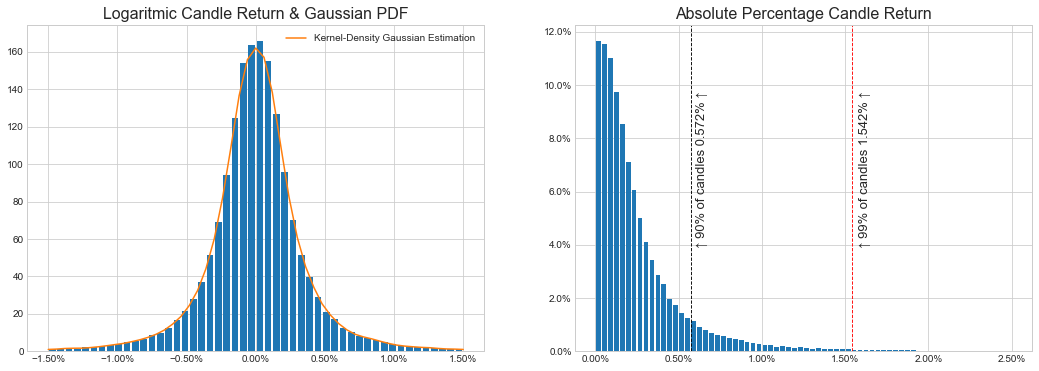

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Logarithmic Return Analysis
axs[0].set_title("Logaritmic Candle Return & Gaussian PDF", fontsize = 16)
n, x, _ = axs[0].hist(btc15['log_ret'], bins = 50, rwidth = 0.8,
         range = (-0.015, 0.015), density = True)
axs[0].plot(x, density(x), label = "Kernel-Density Gaussian Estimation")
axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axs[0].legend()

# Absolute Percentage Return Analysis
axs[1].set_title("Absolute Percentage Candle Return", fontsize = 16)
axs[1].hist(np.abs(btc15['perc_ret']), bins = 70, rwidth = 0.8, range = (0, 0.025),
           weights=np.ones_like(btc15['perc_ret']) / len(btc15['perc_ret']))
axs[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


perc_90 = np.percentile(btc15['perc_ret'].abs(), 90)
perc_99 = np.percentile(btc15['perc_ret'].abs(), 99)
axs[1].axvline(x = perc_90, color = 'black', linestyle = '--', linewidth = 0.9)
axs[1].text(perc_90*1.06, 0.04, f"↑ 90% of candles {round(perc_90*100, 3)}% ↑", rotation = 90, fontsize = 13)
axs[1].axvline(x = perc_99, color = 'red', linestyle = '--', linewidth = 0.9)
axs[1].text(perc_99*1.025, 0.04, f"↑ 99% of candles {round(perc_99*100, 3)}% ↑", rotation = 90, fontsize = 13)

plt.show();

### Indicators and other informations
We derive the indicators and other information from the data available

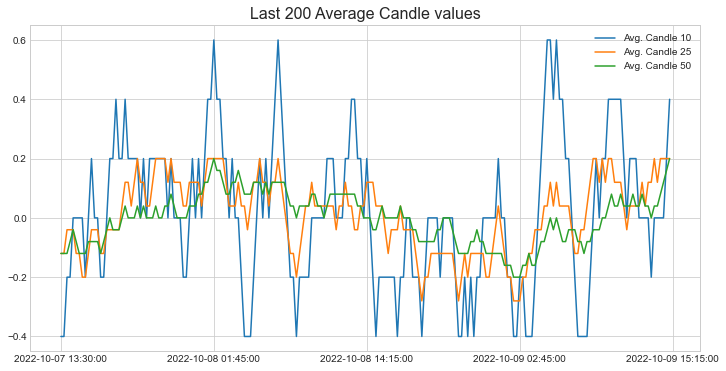

In [12]:
btc15_ind = pd.DataFrame(index = btc15.index) # Create a DataFrame for all the indicators

# Define the candle type (1 = Buy, -1 = Sell)
btc15_ind['candle'] = np.where(btc15['close'] >= btc15['open'], 1, -1)

# Rolling Statistics - Average Candle Type
btc15_ind['avg_cand(10)'] = btc15_ind['candle'].rolling(10).mean() # 10 Periods
btc15_ind['avg_cand(25)'] = btc15_ind['candle'].rolling(25).mean() # 25 Periods
btc15_ind['avg_cand(50)'] = btc15_ind['candle'].rolling(50).mean() # 50 periods

# Plot last 200 values
plt.figure(figsize = (12, 6))

labels = [btc15_ind[-200:].index[int(i)-1] for i in np.linspace(1, len(btc15_ind[-200:].index), 5)]
pos = [int(x) for x in np.linspace(0, len(btc15_ind[-200:].index), 5)]
plt.xticks(pos, labels)

plt.title("Last 200 Average Candle values", fontsize = 16)
plt.plot(btc15_ind['avg_cand(10)'][-200:], label = "Avg. Candle 10")
plt.plot(btc15_ind['avg_cand(25)'][-200:], label = "Avg. Candle 25")
plt.plot(btc15_ind['avg_cand(50)'][-200:], label = "Avg. Candle 50")

plt.legend()
plt.show()

In [13]:
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator

periods = [4, 8, 12, 24, 48, 96]

for p in periods:
    btc15_ind[f'SMA_{p}'] = SMAIndicator(btc15['close'], p).sma_indicator()
    btc15_ind[f'EMA_{p}'] = EMAIndicator(btc15['close'], p).ema_indicator()

btc15_ind

,candle,avg_cand(10),avg_cand(25),avg_cand(50),SMA_4,EMA_4,SMA_8,EMA_8,SMA_12,EMA_12,SMA_24,EMA_24,SMA_48,EMA_48,SMA_96,EMA_96
datetime,,,,,,,,,,,,,,,,
2020-02-17 11:15:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17 11:30:00,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17 11:45:00,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17 12:00:00,1,NaN,NaN,NaN,9619.2175,9618.724160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17 12:15:00,1,NaN,NaN,NaN,9615.4875,9628.522496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-09 14:15:00,-1,0.0,0.12,0.04,19449.2625,19463.475384,19455.22625,19460.464929,19465.907500,19459.498124,19451.563750,19448.185333,19407.615833,19431.155826,19418.501458,19440.062472
2022-10-09 14:30:00,1,0.0,0.20,0.08,19466.3300,19475.945230,19458.60250,19468.061612,19465.909167,19464.906105,19457.590833,19451.902507,19411.441875,19433.747425,19418.553854,19441.187988
2022-10-09 14:45:00,1,0.0,0.20,0.12,19491.4375,19485.539138,19463.78125,19475.143476,19468.340000,19470.294396,19463.582917,19455.744706,19415.627917,19436.448754,19418.738854,19442.399164


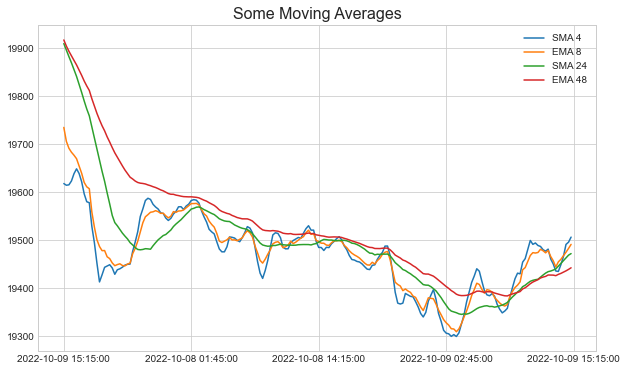

In [14]:
plt.figure(figsize = (10, 6))

labels = [btc15_ind[-200:].index[int(i)-1] for i in np.linspace(0, len(btc15_ind[-200:].index), 5)]
pos = [int(x) for x in np.linspace(0, len(btc15_ind[-200:].index), 5)]

plt.xticks(pos, labels)

plt.title("Some Moving Averages", fontsize = 16)

for ma in btc15_ind.columns[4::3]:
    plt.plot(btc15_ind[ma][-200:], label = ma.replace('_', ' '))

plt.legend()
plt.show()

### Position relative to the moving averages
Use previous values of Moving Averages to find patterns in the dataset. We need to extract the data from the dataframe of indicators first

In [21]:
# A function to identify the position of the candle relative to
# the previous MA value and the kind of candle (Buy or Sell)

def candle_position(candle_df, ma_df):
    
    ma_df = ma_df.shift(1) # Shift MA
    ma_pos_df = pd.DataFrame(index = ma_df.index)
    
    for ma in ma_df.columns:
        ma_pos_df[ma + '_pos'] = np.where(ma_df[ma].isna(), pd.NA,
                                          np.where(candle_df['open'] > ma_df[ma],
                                                   np.where(candle_df['close'] > candle_df['open'], 'Above Buy', 'Above Sell'),
                                                   np.where(candle_df['close'] > candle_df['open'], 'Below Buy', 'Below Sell')))
    return ma_pos_df

def candle_position_freq(ma_pos_df):
    
    ma_pos_freq = {}
    
    for ma in ma_pos_df.columns:
        freq = {}
        for pos in ['Above', 'Below']:
            pos_serie = ma_pos_df[ma].loc[ma_pos_df[ma].str.contains(pos)]
            for t in ['Buy', 'Sell']:
                #print(round(pos_serie.str.contains(t).mean(), 5))
                freq[f'{pos} {t}'] = round(pos_serie.str.contains(t).mean(), 5)
            
        ma_pos_freq[ma.replace('_pos', '')] = freq
    
    return ma_pos_freq

In [54]:
btc15_ma_pos = candle_position(btc15, btc15_ind.iloc[:, 4:]).dropna()
btc15_ma_pos_freq = candle_position_freq(btc15_ma_pos)

After collecting the data, let's start with compare the results of the candle position analysis!

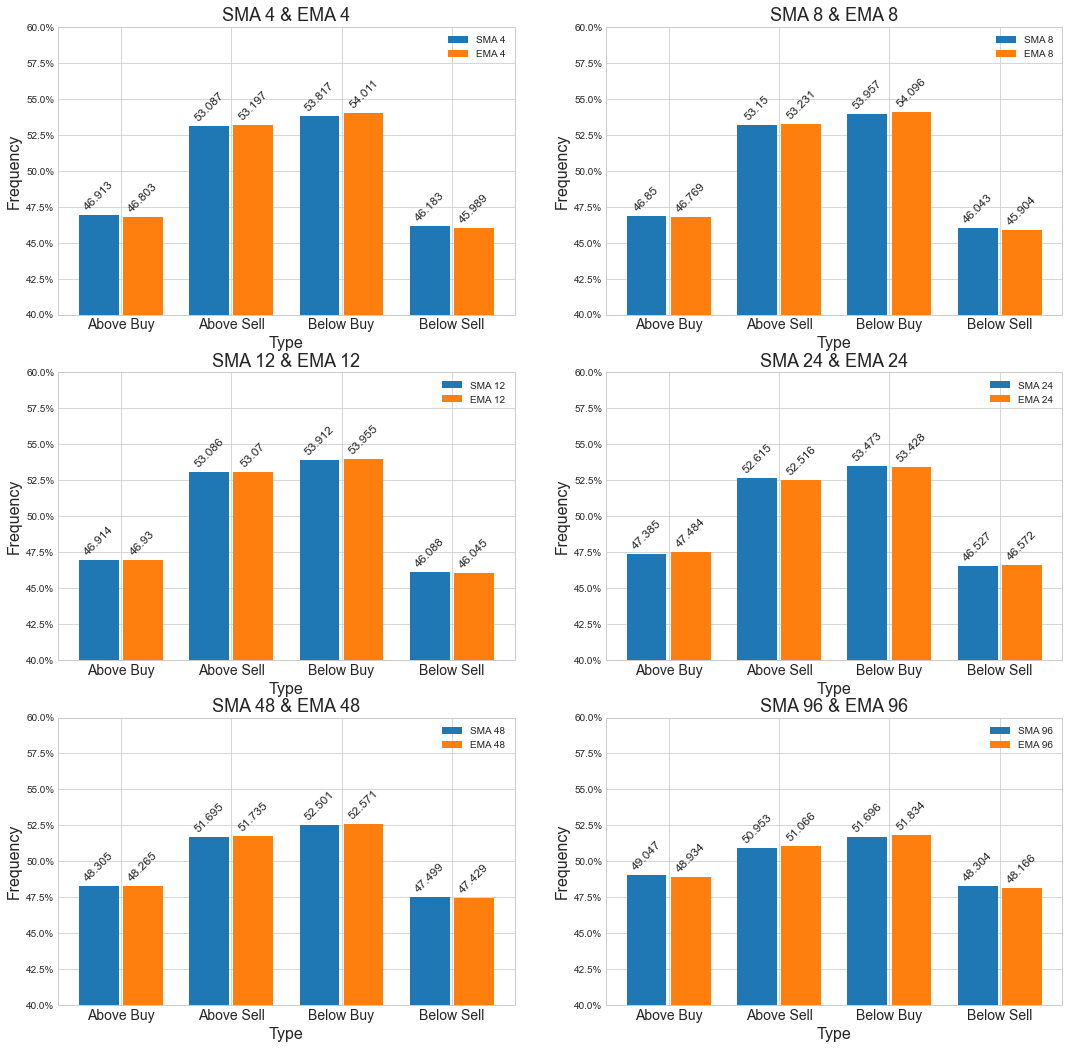

In [76]:
# Comparison between periods
fig, axs = plt.subplots(nrows= 3, ncols=2, figsize=(18, 18))

keys = list(btc15_ma_pos_freq.keys())
x = np.arange(4)
width = 0.40

for n in range(6):
    sma_rect = axs[n // 2][n % 2].bar(x - width/2, [round(x*100, 3) for x in btc15_ma_pos_freq[keys[n*2]].values()],
                          width*0.9, label = keys[n*2].replace('_', ' '))
    ema_rect = axs[n // 2][n % 2].bar(x + width/2, [round(x*100, 3) for x in btc15_ma_pos_freq[keys[n*2+1]].values()],
                          width*0.9, label = keys[n*2 + 1].replace('_', ' '))
    
    
    axs[n // 2][n % 2].set_xlabel('Type', fontsize = 16)
    axs[n // 2][n % 2].set_ylabel('Frequency', fontsize = 16)
    axs[n // 2][n % 2].set_title(f"{keys[n*2].replace('_', ' ')} & {keys[n*2 +1].replace('_', ' ')}", fontsize = 18)
    
    axs[n // 2][n % 2].bar_label(sma_rect, padding=3, rotation = 45, fontsize = 12)
    axs[n // 2][n % 2].bar_label(ema_rect, padding=3, rotation = 45, fontsize = 12)

    axs[n // 2][n % 2].set_xticks(x, btc15_ma_pos_freq[keys[n*2+1]].keys(), fontsize = 14)
    axs[n // 2][n % 2].yaxis.set_major_formatter(mtick.PercentFormatter())
    axs[n // 2][n % 2].set_ylim([40, 60])
    
    axs[n // 2][n % 2].legend()

plt.show()

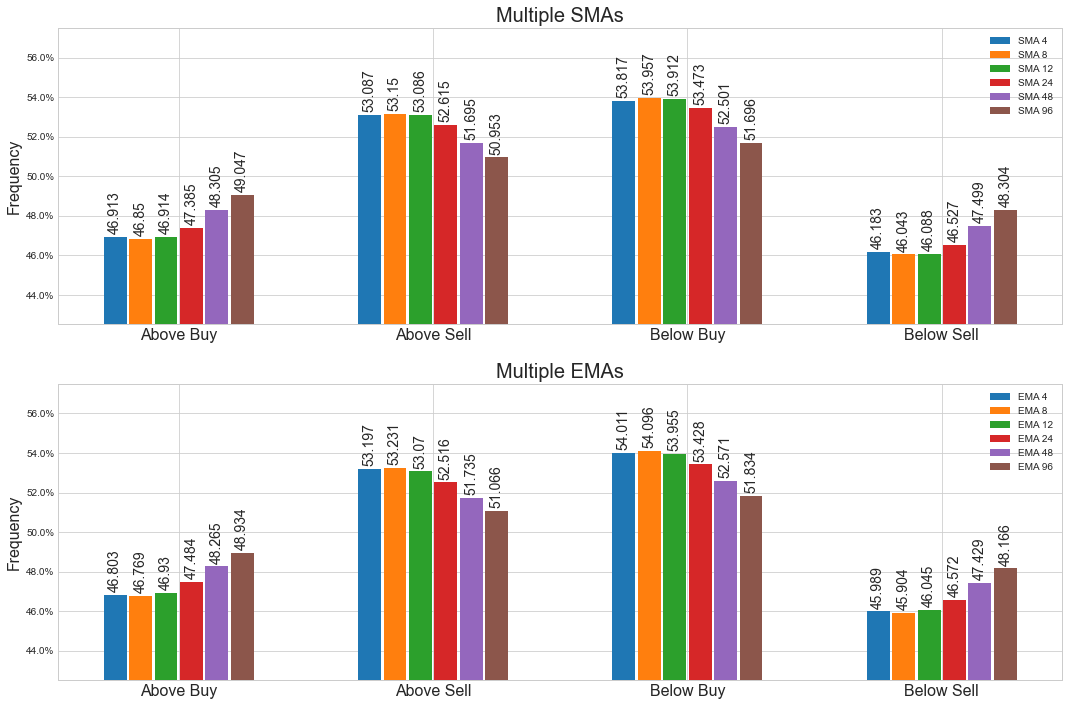

In [110]:
# SMAs and EMAs comparasion
fig, axs = plt.subplots(nrows= 2, ncols=1, figsize=(18, 12))

keys = list(btc15_ma_pos_freq.keys())
x = np.arange(4)
width = 0.1

for n in range(2):
    
    for i in range(6):
        rect = axs[n].bar(x + (i*2-5)*width/2, [round(x*100, 3) for x in btc15_ma_pos_freq[keys[i*2+n]].values()],
                              width*0.9, label = keys[i*2+n].replace('_', ' '))
        axs[n].bar_label(rect, padding=3, rotation = 90, fontsize = 14)
    
    axs[n].set_title(f"Multiple {keys[i*2+n].split('_')[0]}s", fontsize = 20)
    axs[n].set_ylabel('Frequency', fontsize = 16)
    
    axs[n].set_xticks(x, btc15_ma_pos_freq[keys[0+n]].keys(), fontsize = 16)
    axs[n].yaxis.set_major_formatter(mtick.PercentFormatter())
    axs[n].set_ylim([42.5, 57.5])
    
    axs[n].legend()
    

plt.show()

From the results we can see that we can create a mean reverting strategy using the EMA(8). So buy when the open is below the EMA(8) value of the previous candle (it would work 54.096% of time) and sell when the open is above the EMA(8) value of the previous candle (it would work 53.231% of time).

### Strategy Backtest
Now let's make a little backtest of the strategy

In [150]:
bt_buy_ret = btc15['perc_ret'].loc[btc15['open'] < btc15_ind['EMA_8'].shift(1)]
bt_sell_ret = btc15['perc_ret'].loc[btc15['open'] > btc15_ind['EMA_8'].shift(1)]*-1
bt_fin_ret = pd.concat([bt_buy_ret, bt_sell_ret])

bt_buy = np.cumprod(bt_buy_ret + 1)
bt_sell = np.cumprod(bt_sell_ret + 1)
bt_fin = np.cumprod(bt_complexive_ret + 1)

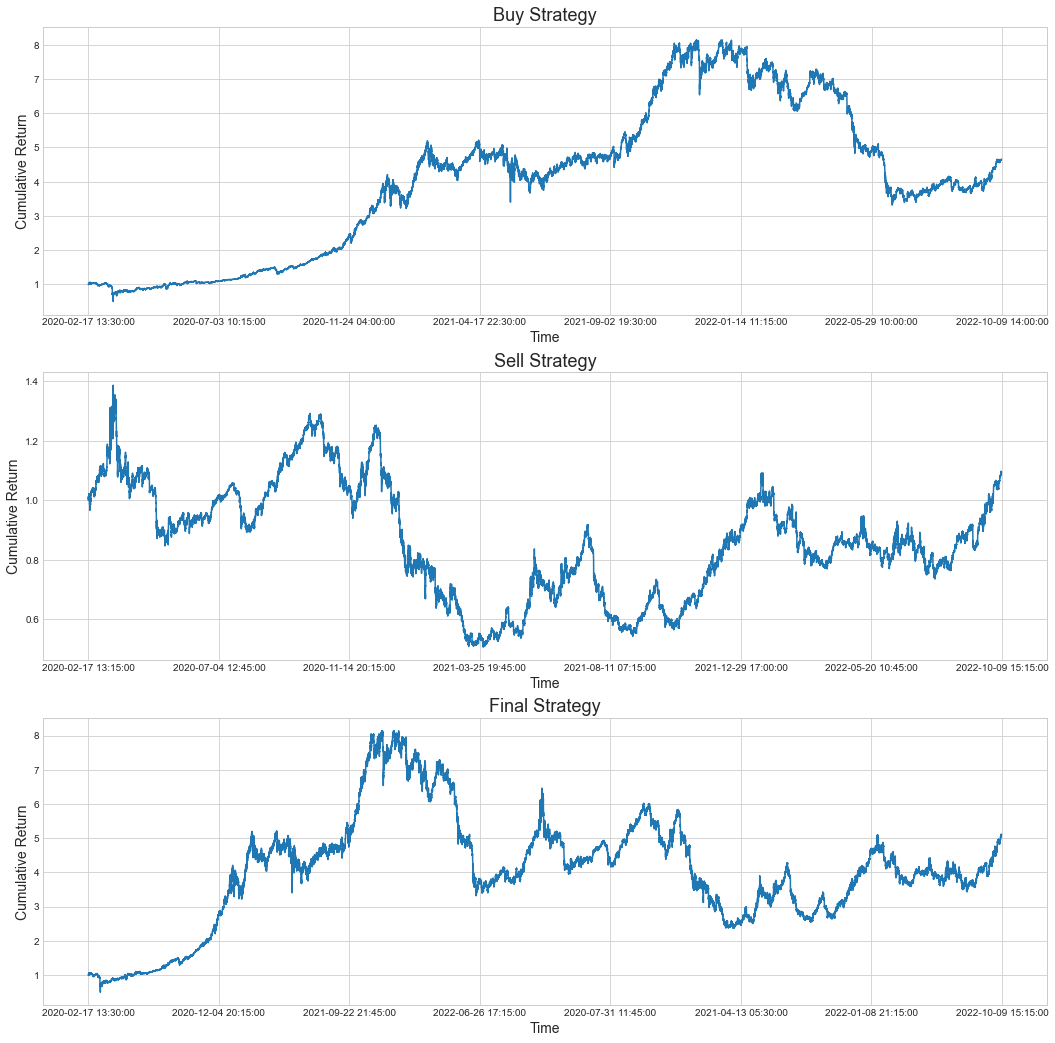

In [152]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (18, 18))

bt_names = ['Buy Strategy', 'Sell Strategy', 'Final Strategy']

for i, bt in zip(range(3), [bt_buy, bt_sell, bt_fin]):
    
    labels = [bt.index[int(i)-1] for i in np.linspace(1, len(bt.index), 8)]
    pos = [int(x) for x in np.linspace(1, len(bt.index), 8)]
    axs[i].set_xticks(pos, labels)
    
    axs[i].set_title(bt_names[i], fontsize = 18)
    axs[i].set_xlabel('Time', fontsize = 14)
    axs[i].set_ylabel('Cumulative Return', fontsize = 14)
    
    axs[i].plot(bt)

Comparing the results of the backtest we can see that the "Sell Strategy" does not show excellent results, while the "Buy Strategy" has a good cumulate return, but in the last period the performance is not so good. So we have one question, how can we improve the performance? Using Machine Learning!

## Performance Improvement with Machine Learning
In this section we will use machine learning algorithms to improve the performance of our strategy. Let's start with adding other indicators to the Indicators DataFrame